## Building CNN model to predict the brain tumor

#### Data Scource : https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import random

In [2]:
categories = {'yes':1,'no':0}

In [3]:
images = []
for cat,label in categories.items():
    folder = cat
    for filname in os.listdir(folder):
        img_path = os.path.join(folder, filname)
        img = Image.open(img_path)
        images.append((img,label))        

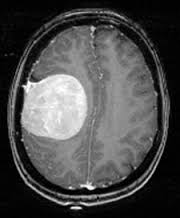

In [6]:
images[0][0]

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

In [8]:
train_transpose = transforms.Compose([transforms.RandomRotation(10),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.Resize(224),transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])])

test_transpose = transforms.Compose([transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])])

In [9]:
random.seed(23)
random.shuffle(images)

In [10]:
images = images[:250]
train_im = images[:200]
test_im = images[200:]

In [11]:
train_vec = []
test_vec = []
for im in train_im:
    tar = im[1]
    im = im[0]
    im = im.convert('RGB')
    im = train_transpose(im)
    train_vec.append((im,tar))

for im in test_im:
    tar = im[1]
    im = im[0]
    im = im.convert('RGB')
    im = test_transpose(im)
    test_vec.append((im,tar))


In [12]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 20, 3, 1)
        self.fc1 = nn.Linear(54*54*20, 80)
        self.fc2 = nn.Linear(80, 60)
        self.fc3 = nn.Linear(60, 40)
        self.fc4 = nn.Linear(40, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*20)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

In [13]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=58320, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=40, bias=True)
  (fc4): Linear(in_features=40, out_features=2, bias=True)
)

In [14]:
torch.manual_seed(42)
train_loader = DataLoader(train_vec, batch_size=10, shuffle=True)
test_loader = DataLoader(test_vec, batch_size=10, shuffle=True)

In [15]:
import time
start_time = time.time()

epochs = 5

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print interim results
        if b%10 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/20]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   10 [   100/20]  loss: 0.49223107  accuracy:  57.000%
epoch:  0  batch:   20 [   200/20]  loss: 0.69986117  accuracy:  65.500%
epoch:  1  batch:   10 [   100/20]  loss: 0.38812461  accuracy:  70.000%
epoch:  1  batch:   20 [   200/20]  loss: 0.32462797  accuracy:  76.500%
epoch:  2  batch:   10 [   100/20]  loss: 0.43149883  accuracy:  84.000%
epoch:  2  batch:   20 [   200/20]  loss: 0.24590929  accuracy:  84.000%
epoch:  3  batch:   10 [   100/20]  loss: 0.13357671  accuracy:  93.000%
epoch:  3  batch:   20 [   200/20]  loss: 0.82533646  accuracy:  93.500%
epoch:  4  batch:   10 [   100/20]  loss: 0.30892831  accuracy:  92.000%
epoch:  4  batch:   20 [   200/20]  loss: 0.14815737  accuracy:  91.000%

Duration: 22 seconds


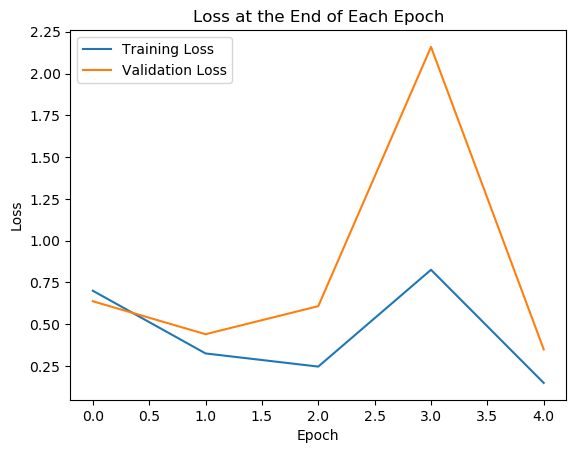

In [16]:
# Convert train_losses and test_losses to lists of floats
train_losses_float = [loss.detach().item() for loss in train_losses]
test_losses_float = [loss.detach().item() for loss in test_losses]

# Plot the values
import matplotlib.pyplot as plt

plt.plot(train_losses_float, label='Training Loss')
plt.plot(test_losses_float, label='Validation Loss')
plt.title('Loss at the End of Each Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [17]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/50:.3f}%')

[tensor(32), tensor(35), tensor(31), tensor(36), tensor(36)]
Test accuracy: 72.000%


In [18]:
print(test_correct)
print(f'Test accuracy: {train_correct[-1].item()*100/200:.3f}%')

[tensor(32), tensor(35), tensor(31), tensor(36), tensor(36)]
Test accuracy: 91.000%


### model building using a Pretrained model   

In [19]:
import torchvision
from torchvision.models import get_model, get_model_weights, list_models
import torchvision.models as models

In [20]:
# List all available models
all_models = list_models()
print(f"All available models: {all_models}")

# List only classification models from torchvision.models
classification_models = list_models(module=torchvision.models)

All available models: ['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'deeplabv3_mobilenet_v3_large', 'deeplabv3_resnet101', 'deeplabv3_resnet50', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'fasterrcnn_mobilenet_v3_large_320_fpn', 'fasterrcnn_mobilenet_v3_large_fpn', 'fasterrcnn_resnet50_fpn', 'fasterrcnn_resnet50_fpn_v2', 'fcn_resnet101', 'fcn_resnet50', 'fcos_resnet50_fpn', 'googlenet', 'inception_v3', 'keypointrcnn_resnet50_fpn', 'lraspp_mobilenet_v3_large', 'maskrcnn_resnet50_fpn', 'maskrcnn_resnet50_fpn_v2', 'maxvit_t', 'mc3_18', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'mvit_v1_b', 'mvit_v2_s', 'quantized_googlenet', 'quantized_inception_v3', '

In [21]:
model = models.resnet50(pretrained = True)
model1 = models.alexnet(pretrained = True)

C:\Users\ramac\anaconda3\anaconda\anaconda\envs\pytorchenv\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\ramac\anaconda3\anaconda\anaconda\envs\pytorchenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\ramac\anaconda3\anaconda\anaconda\envs\pytorchenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be 

In [22]:
model1

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
torch.manual_seed(23)
model1.classifier = nn.Sequential(nn.Linear(9216,1024),nn.ReLU(),nn.Dropout(0.4),nn.Linear(1024,2),nn.LogSoftmax(dim=1))

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.classifier.parameters(), lr=0.001)

In [25]:
model1

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

In [26]:
import time
start_time = time.time()

epochs = 8

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        # Apply the model
        y_pred = model1(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print interim results
        if b%10 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/20]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            # Apply the model
            y_val = model1(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   10 [   100/20]  loss: 1.82327724  accuracy:  60.000%
epoch:  0  batch:   20 [   200/20]  loss: 3.35321379  accuracy:  61.000%
epoch:  1  batch:   10 [   100/20]  loss: 1.07427835  accuracy:  85.000%
epoch:  1  batch:   20 [   200/20]  loss: 0.05130234  accuracy:  87.500%
epoch:  2  batch:   10 [   100/20]  loss: 0.73876035  accuracy:  88.000%
epoch:  2  batch:   20 [   200/20]  loss: 0.01089715  accuracy:  90.500%
epoch:  3  batch:   10 [   100/20]  loss: 0.18246967  accuracy:  94.000%
epoch:  3  batch:   20 [   200/20]  loss: 0.04332829  accuracy:  94.500%
epoch:  4  batch:   10 [   100/20]  loss: 0.01616238  accuracy: 100.000%
epoch:  4  batch:   20 [   200/20]  loss: 0.11376101  accuracy:  99.000%
epoch:  5  batch:   10 [   100/20]  loss: 0.01145536  accuracy: 100.000%
epoch:  5  batch:   20 [   200/20]  loss: 0.01604910  accuracy: 100.000%
epoch:  6  batch:   10 [   100/20]  loss: 0.01443324  accuracy: 100.000%
epoch:  6  batch:   20 [   200/20]  loss: 0.0002210

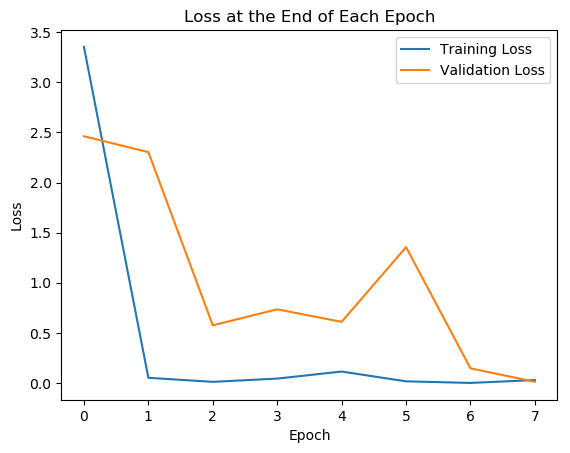

In [27]:
# Convert train_losses and test_losses to lists of floats
train_losses_float = [loss.detach().item() for loss in train_losses]
test_losses_float = [loss.detach().item() for loss in test_losses]

# Plot the values
import matplotlib.pyplot as plt

plt.plot(train_losses_float, label='Training Loss')
plt.plot(test_losses_float, label='Validation Loss')
plt.title('Loss at the End of Each Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [28]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/50:.3f}%')

[tensor(39), tensor(37), tensor(41), tensor(39), tensor(38), tensor(43), tensor(40), tensor(43)]
Test accuracy: 86.000%


In [29]:
print(train_correct)
print(f'Test accuracy: {train_correct[-1].item()*100/200:.3f}%')

[tensor(122), tensor(175), tensor(181), tensor(189), tensor(198), tensor(200), tensor(199), tensor(200)]
Test accuracy: 100.000%


In [39]:
X_test.shape

torch.Size([10, 3, 224, 224])

In [40]:
X_test[0].shape

torch.Size([3, 224, 224])

0


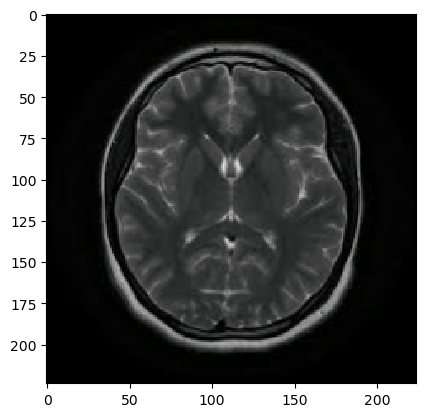

In [61]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im = X_test[0]
im = inv_normalize(im)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
y_val = model1(X_test)
print(y_val[0].argmax().item())